Create compression version of GPT-2 nad BERT model and save the memory =)

## cola example

The Semantic Textual Similarity Benchmark (Cer et al., 2017) is a collection of sentence pairs drawn from news headlines, video and image captions, and natural language inference data. Each pair is human-annotated with a similarity score from 0 to 5.

In [1]:
import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"


In [2]:
#!pip install Partial State

In [3]:
import transformers
print (transformers.__version__)

4.30.2


In [4]:
from sparse_grad2 import replace_bert_layers

In [5]:
def create_space_matrices(model):
    if hasattr(model, "bert") and hasattr(model.bert, "encoder"):
        encoder = model.bert.encoder
    elif hasattr(model, "encoder"):
        encoder = model.encoder
    else:
        raise ValueError("Expected model to have attribute 'encoder' or 'bert.encoder'.")

    for i, layer in enumerate(encoder.layer):
        
        layer.intermediate.dense.create_UV()
          
        layer.output.dense.create_UV()
          
        #print ("new shape", layer.output.dense.weight.shape)
        #print ("\n\n")

    return model

In [6]:
def sparse_grad_linear(model, *args):
    print ("create bert with sparse grads")
    model = replace_bert_layers(model)
    print ("created bert with sparse grads")
    return model

In [7]:
from datasets import load_dataset
import pandas as pd

dataset_cola = load_dataset('glue', 'cola')
dataset_cola.num_rows

Found cached dataset glue (/root/.cache/huggingface/datasets/glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

{'train': 8551, 'validation': 1043, 'test': 1063}

In [8]:
label_list = dataset_cola["train"].features["label"].names
num_labels = len(label_list)


In [9]:
config

Available objects for config:
     AliasManager
     DisplayFormatter
     HistoryManager
     IPCompleter
     IPKernelApp
     InlineBackend
     LoggingMagics
     MagicsManager
     OSMagics
     PrefilterManager
     ScriptMagics
     StoreMagics
     ZMQInteractiveShell


In [10]:
set(pd.DataFrame(dataset_cola['train']).label)

{0, 1}

In [11]:
task_num_labels = num_labels

from transformers import AutoConfig, BertConfig, AutoModelForSequenceClassification, AutoTokenizer

path_name = r"bert-base-uncased"

config = AutoConfig.from_pretrained(
    path_name,
    num_labels=num_labels,
)

model = AutoModelForSequenceClassification.from_pretrained(
    path_name,
    config=config,
)

tokenizer = AutoTokenizer.from_pretrained(path_name)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [18]:
#model=model.to('cuda:2')

In [19]:
task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
}
sentence1_key, sentence2_key = task_to_keys['cola']

In [20]:

def preprocess_function(examples):
        # Tokenize the texts
        args = (
            (examples[sentence1_key],) if sentence2_key is None else (examples[sentence1_key], examples[sentence2_key])
        )
        
        
        result = tokenizer.batch_encode_plus(*args, max_length=128, truncation=True, padding="max_length")

        result["label"] = examples["label"]
        return result

In [21]:
num_labels

2

In [22]:
dataset_cola['train']

Dataset({
    features: ['sentence', 'label', 'idx'],
    num_rows: 8551
})

In [23]:
tokenized_dataset = dataset_cola.map(
            preprocess_function,
            batched=True,
            load_from_cache_file=False
        )

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [24]:
tokenized_dataset['validation']

Dataset({
    features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1043
})

In [25]:
from transformers import Trainer
import evaluate as ev
import numpy as np

from transformers import TrainingArguments, Trainer, EvalPrediction

2023-07-24 23:18:51.376628: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [26]:
metric = ev.load("glue", 'cola')

In [27]:
import numpy as np
import matplotlib.pyplot as plt

In [28]:
def compute_metrics(p: EvalPrediction):
        preds_ = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
        preds_ = np.argmax(preds_, axis=1)
        
        result = metric.compute(predictions=preds_, references=p.label_ids)
        if True:
            result["combined_score"] = np.mean(list(result.values())).item()
            return result
        else:
            return {"accuracy": (preds_ == p.label_ids).astype(np.float32).mean().item()}

In [29]:
training_args1 = TrainingArguments(
    learning_rate=5e-5,
    num_train_epochs=1,
    evaluation_strategy="steps",
    eval_steps=100,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=128,
    save_steps=1000,
    overwrite_output_dir=True,
    output_dir="./bert_stsb_128",
    # The next line is important to ensure the dataset labels are properly passed to the model
    remove_unused_columns=True,
    seed=297104,
    report_to='none',
    )

In [31]:
from trainers_custom import TrainerBert1, TrainerBert2

In [32]:
import torch 

from transformers import Trainer
import evaluate as ev
import numpy as np

from transformers import TrainingArguments, Trainer, EvalPrediction

class TrainerBert1(Trainer):
    
    def make_grad_bank(self):
        self.n_show = 3
        self.losses = []
    
    def training_step(self, model, inputs):
        model.train()
        inputs = self._prepare_inputs(inputs)
        with self.compute_loss_context_manager():
            loss = self.compute_loss(model, inputs)
        loss.backward()
        for layer in range(12):
                
            if (model.bert.encoder.layer[layer].output.dense.len_grads) < 30:
                model.bert.encoder.layer[layer].output.dense.len_grads += 1
                cur_grad = model.bert.encoder.layer[layer].output.dense.weight.grad
                model.bert.encoder.layer[layer].output.dense.grads.append(torch.empty_like(cur_grad).copy_(cur_grad))

            if (model.bert.encoder.layer[layer].intermediate.dense.len_grads) < 30:
                model.bert.encoder.layer[layer].intermediate.dense.len_grads += 1
                cur_grad = model.bert.encoder.layer[layer].intermediate.dense.weight.grad
                model.bert.encoder.layer[layer].intermediate.dense.grads.append(torch.empty_like(cur_grad).copy_(cur_grad))
                

            else:
                
                if (self.n_show > 0):
                    self.n_show -= 1
                    im= plt.imshow(model.bert.encoder.layer[layer].output.dense.weight.grad[:50, :50].cpu().detach().numpy(), cmap='jet', aspect='auto')#not in spy
                    print ("number of nonzero ", torch.count_nonzero(model.bert.encoder.layer[layer].output.dense.weight.grad.cpu().detach()))
                    plt.title('grad '+'20x20 ' + str(self.n_show))
                    plt.colorbar(im) #not in spy
                    plt.show()
                    #plt.colorbar(im2)
                    #plt.show()
                    #plt.colorbar(im3)
                    #plt.show()
                    #plt.colorbar(im4)
                    #plt.show()
                    #plt.colorbar(im5)
                    plt.show()

                    im= plt.imshow(model.bert.encoder.layer[layer].intermediate.dense.weight.grad[:50, :50].cpu().detach().numpy(), cmap='jet', aspect='auto')#not in spy
                    print ("number of nonzero ", torch.count_nonzero(model.bert.encoder.layer[layer].intermediate.dense.weight.grad.cpu().detach()))
                    plt.title('grad '+'20x20 ' + str(self.n_show)) 
                    plt.colorbar(im) #not in spy
                    plt.show()
                
                    
        
        

        self.losses.append(loss.cpu().detach().numpy())
        return loss.detach()

In [33]:
model = sparse_grad_linear(model)

create bert with sparse grads
created bert with sparse grads


In [26]:
trainer = TrainerBert1(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["validation"],
        compute_metrics = compute_metrics
)
trainer.make_grad_bank()

In [27]:
trainer.train_dataset

Dataset({
    features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 8551
})

## BERT sparse

len small dataset 8551
lets collect gradients


/opt/.pyenv/versions/3.8.10/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Matthews Correlation,Combined Score
100,No log,0.477967,0.451401,0.451401
200,No log,0.521984,0.377600,0.377600
300,No log,0.462335,0.489691,0.489691
400,No log,0.406441,0.536506,0.536506
500,0.481700,0.423139,0.544914,0.544914


created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
number of nonzero  tensor(1894)


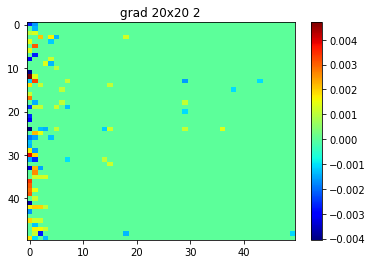

number of nonzero  tensor(4505)


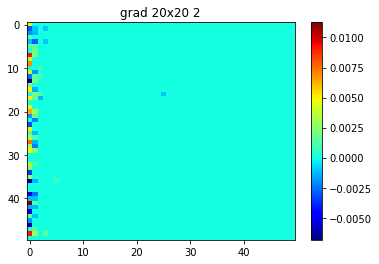

number of nonzero  tensor(2568)


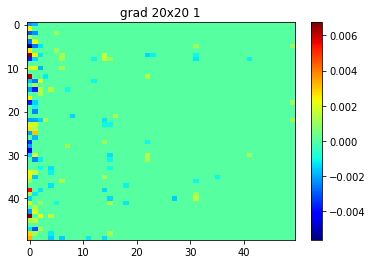

number of nonzero  tensor(5934)


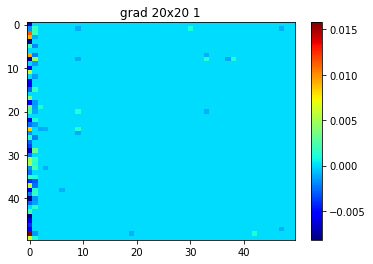

number of nonzero  tensor(3225)


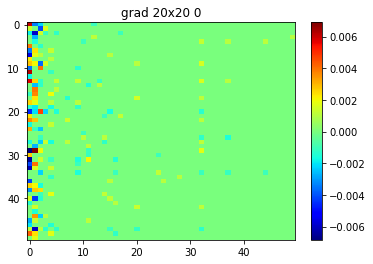

number of nonzero  tensor(9591)


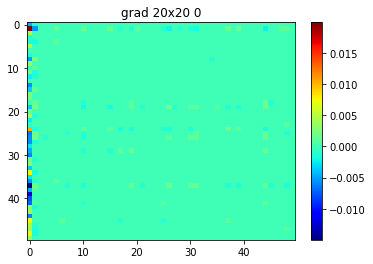

finishing collecting gradients


In [28]:

print ("len small dataset", len(trainer.train_dataset))
print ("lets collect gradients")
train_result = trainer.train()
print ("finishing collecting gradients")
#model = create_space_matrices(model)

In [29]:
trainer.evaluate()

{'eval_loss': 0.4162612557411194,
 'eval_matthews_correlation': 0.5548848010257114,
 'eval_combined_score': 0.5548848010257114,
 'eval_runtime': 3.1931,
 'eval_samples_per_second': 326.637,
 'eval_steps_per_second': 2.819,
 'epoch': 1.0}

In [30]:
eval_losses = [elem['eval_loss'] for elem in trainer.state.log_history if 'eval_loss' in elem.keys()]
import pickle
with open('./cola_pickles/bert_eval_sp_001.pkl', 'wb') as f:
    pickle.dump(np.array(eval_losses), f)

In [31]:
import pickle
with open('./cola_pickles/bert_sp_001.pkl', 'wb') as f:
    pickle.dump(np.array(trainer.losses), f)

In [32]:
import pickle
d = pickle.load( open( "./cola_pickles/bert.pkl", "rb" ) ) 

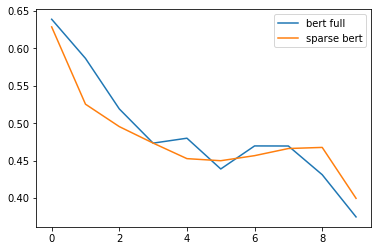

In [33]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.mean(np.array(d)[:500].reshape(-1, 50), axis=1), label = "bert full")
plt.plot(np.mean(np.array(trainer.losses)[:500].reshape(-1, 50), axis=1), label = "sparse bert")
plt.legend()

## EVAL loss

In [34]:
import pickle
#a = pickle.load( open( "./cola_pickles/bert_eval_01.pkl", "rb" ) ) 
b = pickle.load( open( "./cola_pickles/bert_eval_sp_001.pkl", "rb" ) ) 
c = pickle.load( open( "./cola_pickles/bert_eval_sp_0005.pkl", "rb" ) ) 
d = pickle.load( open( "./cola_pickles/bert_eval.pkl", "rb" ) ) 
e = pickle.load( open( "./cola_pickles/bert_eval_sp.pkl", "rb" ) ) 

In [35]:
len(b)

6

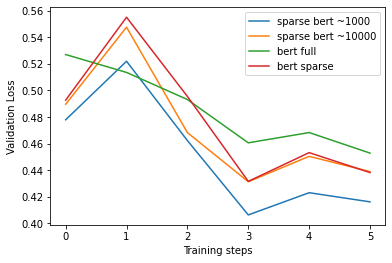

In [36]:
import matplotlib.pyplot as plt
import numpy as np
#plt.plot(np.array(a)[:10], label = "sparse bert ~10")
plt.plot(np.array(b)[:10], label = "sparse bert ~1000")
plt.plot(np.array(c)[:10], label = "sparse bert ~10000")
plt.plot(np.array(d)[:10], label = "bert full")
plt.plot(np.array(e)[:10], label = "bert sparse")

plt.xlabel("Training steps")
plt.ylabel("Validation Loss")
plt.legend()
plt.savefig("freeze0.png")
plt.show()

## Train loss

In [37]:
import pickle
a = pickle.load( open( "./cola_pickles/bert_eval_01.pkl", "rb" ) ) 
b = pickle.load( open( "./cola_pickles/bert_sp_0005.pkl", "rb" ) ) 
c = pickle.load( open( "./cola_pickles/bert_sp_001.pkl", "rb" ) ) 
d = pickle.load( open( "./cola_pickles/bert.pkl", "rb" ) ) 
e = pickle.load( open( "./cola_pickles/bert_sp.pkl", "rb" ) ) 

In [38]:
len(d)

535

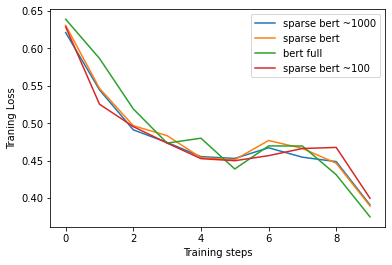

In [40]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.mean(np.array(b)[:500].reshape(-1, 50), axis=1), label = "sparse bert ~1000")
plt.plot(np.mean(np.array(e)[:500].reshape(-1, 50), axis=1), label = "sparse bert")
plt.plot(np.mean(np.array(d)[:500].reshape(-1, 50), axis=1), label = "bert full")
plt.plot(np.mean(np.array(c)[:500].reshape(-1, 50), axis=1), label = "sparse bert ~100")

plt.xlabel("Training steps")
plt.ylabel("Traning Loss")
plt.legend()
plt.savefig("cola_traning.png")
plt.show()